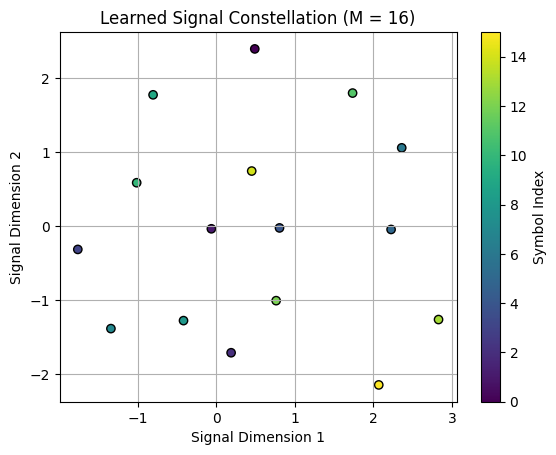

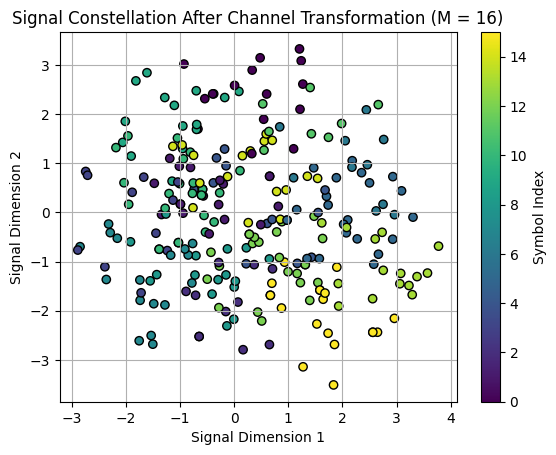

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
M = 16  # Number of possible symbols (messages)
n = 2  # Each symbol is mapped to a 2d signal representation
batch_size = 256  # number of symbols per training iteration
epochs = 100
learning_rate = 0.01  # how much weights can change per training iteration

# Generate random symbols as input
def generate_symbols(batch_size, M):
    return torch.randint(0, M, (batch_size,))  # generate (batch_size) random symbols between 0 and M - 1

def create_windows(data, window_size, step_size):
    num_windows = (len(data) - window_size) // step_size + 1
    windows = torch.stack([
        data[i:i + window_size]  # Extract rows for each window
        for i in range(0, num_windows * step_size, step_size)
    ])

    return windows

# Test model accuracy after training
def test_model(transmitter, channel, receiver, batch_size, M):
    # Generate test symbols
    test_symbols = generate_symbols(batch_size, M)

    # Forward pass (transmit -> channel -> receive)
    transmitted = transmitter(test_symbols)
    received = channel(transmitted)
    decoded_logits = receiver(received)  # Log probabilities

    # Get predicted symbols (index of the highest log probability)
    predicted_symbols = torch.argmax(decoded_logits, dim=1)

    # Compute accuracy
    accuracy = (predicted_symbols == test_symbols).float().mean().item()

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Transmitter (Encoder) - Maps symbols to signals
class Transmitter(nn.Module):
    def __init__(self, M, n):
        super(Transmitter, self).__init__()
        self.embedding = nn.Embedding(M, n)  # Each symbol gets an n-dimensional representation, initially random uniform weights

    def forward(self, x):
        return self.embedding(x)  # Lookup table for embeddings


# Channel - Applies the transformation y_n = x_n - 0.5*x_(n-1) ** 2 + 0.1*x_(n-2) + noise (gaussian)
class Channel(nn.Module):
    def __init__(self, noise_variance=0.1):
        super(Channel, self).__init__()
        self.noise_variance = noise_variance
    def forward(self, x):
        # TODO Generate noise

        # Apply channel transformation
        y = torch.zeros_like(x)
        for i in range(x.shape[0]):
          if i == 0:
            y[i] = x[i]
          elif i == 1:
            y[i] = x[i] -0.5 * x[i - 1]
          else:
            y[i] = x[i] - 0.5 * x[i - 1] + 0.1 * x[i - 2]

        return y

# Receiver (Decoder) - Maps received signals back to symbols
class Receiver(nn.Module):
    def __init__(self, n, M):
        super(Receiver, self).__init__()
        self.fc1 = nn.Linear(5 * n, 64)  # takes in 5 x 2 dimensional inputs
        self.fc2 = nn.Linear(64, M)  # Output is probability distribution over M symbols

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Log-softmax for classification

# Define Model
transmitter = Transmitter(M, n)
channel = Channel()
receiver = Receiver(n, M)

# Optimizer and Loss Function
criterion = nn.NLLLoss()  # Negative Log Likelihood for classification
optimizer = optim.Adam(list(transmitter.parameters()) + list(receiver.parameters()), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    optimizer.zero_grad()

    # Generate random symbols as input
    batch_symbols = generate_symbols(256, M)

    # Forward Pass
    transmitted = transmitter(batch_symbols)

    received = channel(transmitted)

    # Append 0 vectors to beginning and end of received
    zero_padding = torch.zeros(2, received.shape[1])
    received_padded = torch.cat((zero_padding, received, zero_padding), dim=0)

    # Create sliding window inputs for receiver
    windowed_received = create_windows(received_padded, 5, 1)  # todo make sure first window lines up with first symbol
    windowed_received = windowed_received.view(windowed_received.shape[0], -1)  # torch.Size([256, 10]) -> reshape to 256 vectors of 10

    decoded = receiver(windowed_received)

    windowed_targets = batch_symbols

    loss = criterion(decoded, windowed_targets)

    # Backward Pass
    loss.backward()
    optimizer.step()

    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    # Check if embedding weights are changing (embedding is learning) -> YES
    # print(transmitter.embedding.weight)

# Plot each dimension
# plt.figure(figsize=(10, 5))

# # First dimension
# plt.plot(transmitted.detach().numpy()[:, 0], "b--", label="Transmitted Dim 1")  # Dotted = original
# plt.plot(received.detach().numpy()[:, 0], "b-", label="Received Dim 1")  # Solid = after channel
# plt.plot(decoded.detach().numpy()[:, 0], "b-.", label="Decoded Dim 1")  # Dash-dot = after receiver

# # Second dimension
# plt.plot(transmitted.detach().numpy()[:, 1], "r--", label="Transmitted Dim 2")
# plt.plot(received.detach().numpy()[:, 1], "r-", label="Received Dim 2")
# plt.plot(decoded.detach().numpy()[:, 1], "r-.", label="Decoded Dim 2")

# plt.xlabel("Symbol Index")
# plt.ylabel("Signal Value")
# plt.title("Signal Evolution: Transmitted → Received → Decoded")
# plt.legend()
# plt.grid()
# plt.show()

# Visualize Transmitter's Learned Signal Space
embedded_signals = transmitter(torch.arange(M)).detach().numpy()
plt.scatter(embedded_signals[:, 0], embedded_signals[:, 1], c=np.arange(M), cmap='viridis', edgecolors='k')
plt.title("Learned Signal Constellation (M = 16)")
plt.xlabel("Signal Dimension 1")
plt.ylabel("Signal Dimension 2")
plt.colorbar(label="Symbol Index")
plt.grid()
plt.show()

# Visualize Channel Modification (TODO time series visualization?)
plt.scatter(received[:, 0].detach().numpy(), received[:, 1].detach().numpy(), c=batch_symbols.detach().numpy(), cmap='viridis', edgecolors='k')
plt.title("Signal Constellation After Channel Transformation (M = 16)")
plt.xlabel("Signal Dimension 1")
plt.ylabel("Signal Dimension 2")
plt.colorbar(label="Symbol Index")
plt.grid()
plt.show()
